In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler

## Espacios públicos gdl

In [3]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."
2,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672494.325 2272095.205, 672480.366 2..."
3,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672480.366 2272060.731, 672494.325 2..."
4,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672468.717 2272020.613, 672456.895 2..."


In [3]:
gdf.shape

(8499, 4)

## Hexágonos GDL

In [4]:
hex_schema = "hexgrid"
hex_table = "hexgrid_8_city"
c = 'Guadalajara'
query = f'SELECT * FROM {hex_schema}.{hex_table} WHERE \"metropolis\" LIKE \'{c}\''
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdl.head(5)

,geometry,hex_id_8,CVEGEO,metropolis
0,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",8849abc91bfffff,14002,Guadalajara
1,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",8849abc953fffff,14002,Guadalajara
2,"POLYGON ((-103.58960 20.38835, -103.58905 20.3...",8849abc901fffff,14002,Guadalajara
3,"POLYGON ((-103.66739 20.43582, -103.66683 20.4...",8849abc8adfffff,14002,Guadalajara
4,"POLYGON ((-103.66904 20.45140, -103.66452 20.4...",8849ab5249fffff,14002,Guadalajara


## Intersección

In [5]:
gdf = gdf.to_crs(hex_gdl.crs)
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: epsg:4326
CRS of hex_gdl: epsg:4326


In [6]:
inter_Gdl = gpd.sjoin(hex_gdl, gdf, op='intersects')
inter_Gdl

,geometry,hex_id_8,CVEGEO,metropolis,index_right,Fuente,Tipo,Uso
183,"POLYGON ((-103.36270 20.63071, -103.36778 20.6...",88498c9653fffff,14039,Guadalajara,3521,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo
326,"POLYGON ((-103.36832 20.63804, -103.37340 20.6...",8849ab5925fffff,14039,Guadalajara,3521,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo
184,"POLYGON ((-103.34995 20.69490, -103.34941 20.6...",88498c96a5fffff,14039,Guadalajara,5578,"Carta topográfica1:20,000, INEGI.",Glorieta,Sin uso recreativo
184,"POLYGON ((-103.34995 20.69490, -103.34941 20.6...",88498c96a5fffff,14039,Guadalajara,7475,"Digitalizado por IIEG, 2018.",Camellón,Sin uso recreativo
184,"POLYGON ((-103.34995 20.69490, -103.34941 20.6...",88498c96a5fffff,14039,Guadalajara,7477,"Digitalizado por IIEG, 2018.",Camellón,Sin uso recreativo
...,...,...,...,...,...,...,...,...
3265,"POLYGON ((-103.46593 20.82810, -103.47047 20.8...",8849ab48e5fffff,14120,Guadalajara,278,Instrumentos de planeación urbana. Disponible:...,Espacio verde vecinal,Sin uso recreativo
3265,"POLYGON ((-103.46593 20.82810, -103.47047 20.8...",8849ab48e5fffff,14120,Guadalajara,279,Instrumentos de planeación urbana. Disponible:...,Espacio verde vecinal,Sin uso recreativo
3265,"POLYGON ((-103.46593 20.82810, -103.47047 20.8...",8849ab48e5fffff,14120,Guadalajara,284,Instrumentos de planeación urbana. Disponible:...,Glorieta,Sin uso recreativo
3265,"POLYGON ((-103.46593 20.82810, -103.47047 20.8...",8849ab48e5fffff,14120,Guadalajara,280,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo


In [7]:
def mapear_tipo(valor):
    tipos_1 = ['Parque', 'Plaza', 'Área natural', 'Unidad deportiva', 'Espacio verde vecinal', 'Área natural protegida']
    if valor in tipos_1:
        return 1
    elif valor in ['Glorieta', 'Camellón']:
        return 0
    else:
        return None  # Puedes cambiar esto si deseas manejar otros valores

# Aplicar la función para crear la nueva columna
inter_Gdl['EspVerPub'] = inter_Gdl['Tipo'].apply(mapear_tipo)
inter_Gdl.drop(columns=['index_right','Fuente','Uso'], inplace=True)

## Hexágonos con info de humedad, vegetación y temperatura

select {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res,

temperature_std, temperature_median, temperature_max, temperature_min, temperature_diff, temperature_tend,temp_diff_mean,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_std, ndmi_median, ndmi_max, ndmi_min, ndmi_diff, ndmi_tend

from raster_analysis.temperature_analysis_hex tempe

inner join raster_analysis.ndmi_analysis_hex ndmi

on tempe.hex_id = ndmi.hex_id 

inner join raster_analysis.ndvi_analysis_hex ndvi

on tempe.hex_id = ndvi.hex_id 

where tempe.city  = 'Guadalajara' and tempe.res = 11

In [ ]:
#hex_schema = "raster_analysis"
#hex_table = "temperature_analysis_hex"
#hex_tabl = "ndvi_analysis_hex"
#hex_tablee = "ndmi_analysis_hex"
#tempe = "tempe"
#ndmi = "ndmi"
#ndvi = "ndvi"
#hex_id = "hex_id"
#c = 'Guadalajara'
#n = '11'
#query = f'SELECT {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res, temperature_std, temperature_median, temperature_max, temperature_min, temperature_diff, temperature_tend,temp_diff_mean,ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_std, ndmi_median, ndmi_max, ndmi_min, ndmi_diff, ndmi_tend FROM {hex_schema}.{hex_table} {tempe} INNER JOIN {hex_schema}.{hex_tablee} {ndmi} ON {tempe}.{hex_id} = {ndmi}.{hex_id} INNER JOIN {hex_schema}.{hex_tabl} {ndvi} ON {tempe}.{hex_id} = {ndvi}.{hex_id} WHERE {tempe}.\"city\" = \'{c}\' AND {tempe}.\"res\" = {n}'
#int_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#int_gdl.head(10)

select {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res,

temp_diff_mean,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.temperature_analysis_hex tempe

inner join raster_analysis.ndmi_analysis_hex ndmi

on tempe.hex_id = ndmi.hex_id 

inner join raster_analysis.ndvi_analysis_hex ndvi

on tempe.hex_id = ndvi.hex_id 

where tempe.city  = 'Guadalajara' and tempe.res = 11

In [8]:
hex_schema = "raster_analysis"
hex_table = "temperature_analysis_hex"
hex_tabl = "ndvi_analysis_hex"
hex_tablee = "ndmi_analysis_hex"
tempe = "tempe"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'Guadalajara'
n = '11'
query = f'SELECT {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res, temp_diff_mean,ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {tempe} INNER JOIN {hex_schema}.{hex_tablee} {ndmi} ON {tempe}.{hex_id} = {ndmi}.{hex_id} INNER JOIN {hex_schema}.{hex_tabl} {ndvi} ON {tempe}.{hex_id} = {ndvi}.{hex_id} WHERE {tempe}.\"city\" = \'{c}\' AND {tempe}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b4215fff,"POLYGON ((-103.42405 20.71621, -103.42388 20.7...",Guadalajara,11,-1.284982,0.229957,0.058042,0.231979,0.294319,0.163942,0.130377,-0.001144,0.039065,0.029549,0.105781
1,8b49ab4b42cefff,"POLYGON ((-103.42499 20.72046, -103.42482 20.7...",Guadalajara,11,-0.379456,0.224639,0.081781,0.216309,0.322233,0.129293,0.192940,-0.001084,0.009989,0.005061,0.193035
2,8b49ab4b5c93fff,"POLYGON ((-103.42983 20.71742, -103.42966 20.7...",Guadalajara,11,-0.073338,0.433094,0.167217,0.395738,0.700481,0.225127,0.475354,-0.001176,0.082031,0.062196,0.297254
3,8b49ab4b43aefff,"POLYGON ((-103.42292 20.71391, -103.42274 20.7...",Guadalajara,11,-2.462921,0.351869,0.089766,0.372834,0.431929,0.227313,0.204616,-0.001806,0.089015,0.083834,0.117537
4,8b49ab4b4364fff,"POLYGON ((-103.42889 20.71318, -103.42872 20.7...",Guadalajara,11,-0.496962,0.483932,0.102783,0.516193,0.560024,0.355706,0.204318,-0.000635,0.170704,0.170154,0.102290
5,8b49ab4b4244fff,"POLYGON ((-103.42798 20.71776, -103.42781 20.7...",Guadalajara,11,-1.213368,0.516648,0.127617,0.526840,0.621555,0.346370,0.275185,-0.001570,0.176541,0.175209,0.160745
6,8b49ab4b4259fff,"POLYGON ((-103.42779 20.71971, -103.42761 20.7...",Guadalajara,11,0.939236,0.357693,0.200747,0.289348,0.703857,0.158179,0.545678,-0.001155,0.002265,-0.055339,0.404973
7,8b49ab483075fff,"POLYGON ((-103.45665 20.80869, -103.45647 20.8...",Guadalajara,11,-0.282639,0.296540,0.058069,0.311797,0.343975,0.191514,0.152461,-0.001677,0.122609,0.123036,0.099242
8,8b49ab483005fff,"POLYGON ((-103.45447 20.80777, -103.45429 20.8...",Guadalajara,11,1.844519,0.120235,0.026140,0.122106,0.147014,0.097501,0.049513,-0.000783,-0.048292,-0.054991,0.093217
9,8b49ab4830d1fff,"POLYGON ((-103.45271 20.81180, -103.45253 20.8...",Guadalajara,11,-0.056597,0.440252,0.260666,0.418498,0.781023,0.128774,0.652249,-0.000837,0.112624,0.077349,0.444625


In [9]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
inter_Gdl = inter_Gdl.set_crs("EPSG:4326")

In [ ]:
inter = gpd.sjoin(intt_gdl, inter_Gdl, op='intersects')
inter.drop(columns=['index_right','city','res'], inplace=True)
inter.head()

In [12]:
inter.shape

(3930168, 18)

In [13]:
pd.isna(inter).sum()

hex_id            0
geometry          0
temp_diff_mean    0
ndvi_mean         0
ndvi_std          0
ndvi_median       0
ndvi_max          0
ndvi_min          0
ndvi_diff         0
ndvi_tend         0
ndmi_mean         0
ndmi_median       0
ndmi_diff         0
hex_id_8          0
CVEGEO            0
metropolis        0
Tipo              0
EspVerPub         0
dtype: int64

# Métodos de Clasificación

## Regresión Logística

In [14]:
y = inter['EspVerPub']
x = inter[['temp_diff_mean', 'ndmi_median', 'ndmi_mean', 'ndmi_diff', 'ndvi_tend','ndvi_diff','ndvi_min','ndvi_max','ndvi_median','ndvi_std','ndvi_mean']]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

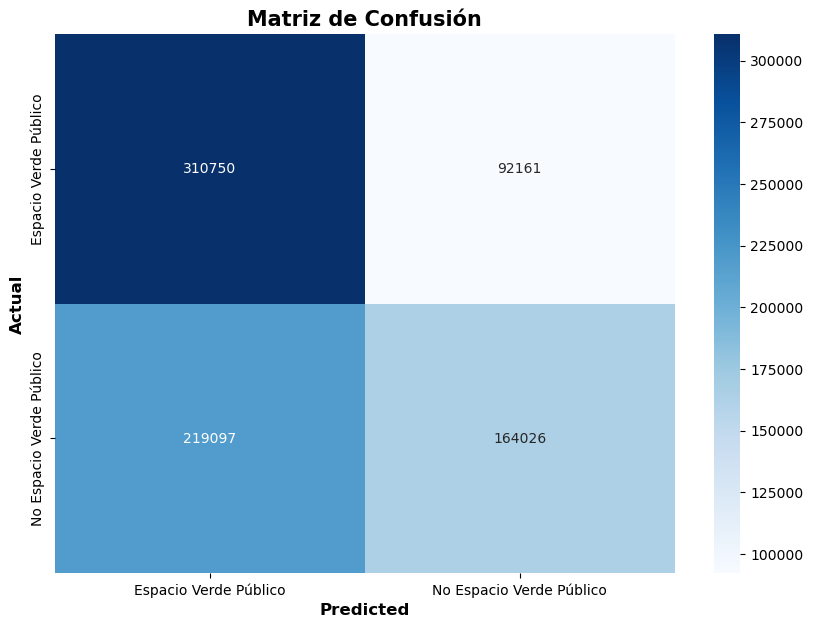

In [15]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [16]:
round(accuracy_score(y_test, y_pred), 4)

0.604

## Naive Bayes

In [17]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

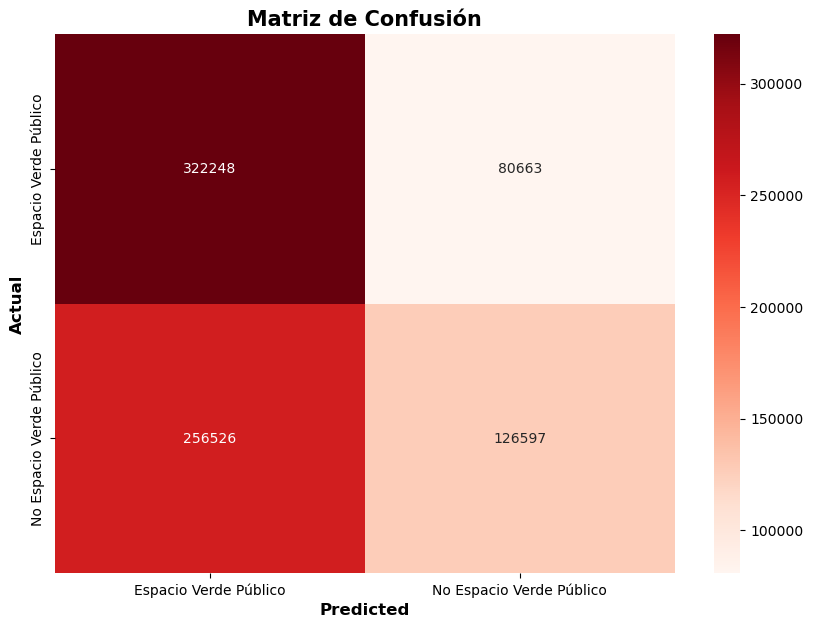

In [18]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5710249174972075


Sigue siendo mucho Espacio Verde Público porque lo más seguro es que tenemos muchos hexágonos con espacio público presente y tenemos muy pocos hexágonos con espacio público no presente. Entonces ahora se intentará hacer un submuestreo para ver si ese es el problema.

## Submuestreo

In [10]:
y = inter['EspVerPub']
x = inter[['temp_diff_mean', 'ndmi_median', 'ndmi_mean', 'ndmi_diff', 'ndvi_tend','ndvi_diff','ndvi_min','ndvi_max','ndvi_median','ndvi_std','ndvi_mean']]
clase2=0
clase3=0

for i in y:
  if i==1:
    clase2+=1
  elif i == 0:
    clase3+=1

print(f"\nLa clase 1 tiene {clase2} observaciones")
print(f"\nLa clase 2 tiene {clase3} observaciones")


La clase 1 tiene 1914977 observaciones

La clase 2 tiene 2015191 observaciones


In [11]:
rus = RandomUnderSampler(sampling_strategy="majority")

In [12]:
xL, yL = rus.fit_resample(x, y)

In [13]:
clase2=0
clase3=0

for i in yL:
  if i==1:
    clase2+=1
  elif i == 0:
    clase3+=1

print(f"\nLa clase 1 tiene {clase2} observaciones")
print(f"\nLa clase 2 tiene {clase3} observaciones")


La clase 1 tiene 1914977 observaciones

La clase 2 tiene 1914977 observaciones


Ya que tenemos la misma cantidad de observaciones, veremos como se comportan los métodos de clasificación

## Métodos de clasificación

### Regresión Logística

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(xL,yL, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

In [ ]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
round(accuracy_score(y_test, y_pred), 4)

### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(x_train, y_train)

In [ ]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')